In [7]:
"""
    Generic data loading routines for the SEN12MS dataset of corresponding Sentinel 1,
    Sentinel 2 and Modis LandCover data.

    The SEN12MS class is meant to provide a set of helper routines for loading individual
    image patches as well as triplets of patches from the dataset. These routines can easily
    be wrapped or extended for use with many deep learning frameworks or as standalone helper 
    methods. For an example use case please see the "main" routine at the end of this file.

    NOTE: Some folder/file existence and validity checks are implemented but it is 
          by no means complete.

    Author: Lloyd Hughes (lloyd.hughes@tum.de)
"""

import os
import rasterio

import matplotlib.pyplot as plt
import numpy as np

from enum import Enum
from glob import glob


class S1Bands(Enum):
    VV = 1
    VH = 2
    ALL = [VV, VH]
    NONE = []


class S2Bands(Enum):
    B01 = aerosol = 1
    B02 = blue = 2
    B03 = green = 3
    B04 = red = 4
    B05 = re1 = 5
    B06 = re2 = 6
    B07 = re3 = 7
    B08 = nir1 = 8
    B08A = nir2 = 9
    B09 = vapor = 10
    B10 = cirrus = 11
    B11 = swir1 = 12
    B12 = swir2 = 13
    ALL = [B01, B02, B03, B04, B05, B06, B07, B08, B08A, B09, B10, B11, B12]
    RGB = [B04, B03, B02]
    NONE = []


class LCBands(Enum):
    IGBP = igbp = 1
    LCCS1 = landcover = 2
    LCCS2 = landuse = 3
    LCCS3 = hydrology = 4
    ALL = [IGBP, LCCS1, LCCS2, LCCS3]
    NONE = []


class Seasons(Enum):
    SPRING = "ROIs1158_spring"
    SUMMER = "ROIs1868_summer"
    FALL = "ROIs1970_fall"
    WINTER = "ROIs2017_winter"
    ALL = [SPRING, SUMMER, FALL, WINTER]


class Sensor(Enum):
    s1 = "s1"
    s2 = "s2"
    lc = "lc"

# Note: The order in which you request the bands is the same order they will be returned in.


class SEN12MSDataset:
    def __init__(self, base_dir):
        self.base_dir = base_dir

        if not os.path.exists(self.base_dir):
            raise Exception(
                "The specified base_dir for SEN12MS dataset does not exist")

    """
        Returns a list of scene ids for a specific season.
    """

    def get_scene_ids(self, season):
        season = Seasons(season).value
        path = os.path.join(self.base_dir, season)

        if not os.path.exists(path):
            raise NameError("Could not find season {} in base directory {}".format(
                season, self.base_dir))

        scene_list = [os.path.basename(s)
                      for s in glob(os.path.join(path, "*"))]
        scene_list = [int(s.split('_')[1]) for s in scene_list]
        return set(scene_list)

    """
        Returns a list of patch ids for a specific scene within a specific season
    """

    def get_patch_ids(self, season, scene_id):
        season = Seasons(season).value
        path = os.path.join(self.base_dir, season, f"s1_{scene_id}")

        if not os.path.exists(path):
            raise NameError(
                "Could not find scene {} within season {}".format(scene_id, season))

        patch_ids = [os.path.splitext(os.path.basename(p))[0]
                     for p in glob(os.path.join(path, "*"))]
        patch_ids = [int(p.rsplit("_", 1)[1].split("p")[1]) for p in patch_ids]

        return patch_ids

    """
        Return a dict of scene ids and their corresponding patch ids.
        key => scene_ids, value => list of patch_ids
    """

    def get_season_ids(self, season):
        season = Seasons(season).value
        ids = {}
        scene_ids = self.get_scene_ids(season)

        for sid in scene_ids:
            ids[sid] = self.get_patch_ids(season, sid)

        return ids

    """
        Returns raster data and image bounds for the defined bands of a specific patch
        This method only loads a sinlge patch from a single sensor as defined by the bands specified
    """

    def get_patch(self, season, scene_id, patch_id, bands):
        season = Seasons(season).value
        sensor = None

        if isinstance(bands, (list, tuple)):
            b = bands[0]
        else:
            b = bands
        
        if isinstance(b, S1Bands):
            sensor = Sensor.s1.value
            bandEnum = S1Bands
        elif isinstance(b, S2Bands):
            sensor = Sensor.s2.value
            bandEnum = S2Bands
        elif isinstance(b, LCBands):
            sensor = Sensor.lc.value
            bandEnum = LCBands
        else:
            raise Exception("Invalid bands specified")

        if isinstance(bands, (list, tuple)):
            bands = [b.value for b in bands]
        else:
            bands = bands.value

        scene = "{}_{}".format(sensor, scene_id)
        filename = "{}_{}_p{}.tif".format(season, scene, patch_id)
        patch_path = os.path.join(self.base_dir, season, scene, filename)

        with rasterio.open(patch_path) as patch:
            data = patch.read(bands)
            bounds = patch.bounds

        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)

        return data, bounds

    """
        Returns a triplet of patches. S1, S2 and LC as well as the geo-bounds of the patch
    """

    def get_s1s2lc_triplet(self, season, scene_id, patch_id, s1_bands=S1Bands.ALL, s2_bands=S2Bands.ALL, lc_bands=LCBands.ALL):
        s1, bounds = self.get_patch(season, scene_id, patch_id, s1_bands)
        s2, _ = self.get_patch(season, scene_id, patch_id, s2_bands)
        lc, _ = self.get_patch(season, scene_id, patch_id, lc_bands)

        return s1, s2, lc, bounds

    """
        Returns a triplet of numpy arrays with dimensions D, B, W, H where D is the number of patches specified
        using scene_ids and patch_ids and B is the number of bands for S1, S2 or LC
    """

    def get_triplets(self, season, scene_ids=None, patch_ids=None, s1_bands=S1Bands.ALL, s2_bands=S2Bands.ALL, lc_bands=LCBands.ALL):
        season = Seasons(season)
        scene_list = []
        patch_list = []
        bounds = []
        s1_data = []
        s2_data = []
        lc_data = []

        # This is due to the fact that not all patch ids are available in all scenes
        # And not all scenes exist in all seasons
        if isinstance(scene_ids, list) and isinstance(patch_ids, list):
            raise Exception("Only scene_ids or patch_ids can be a list, not both.")

        if scene_ids is None:
            scene_list = self.get_scene_ids(season)
        else:
            try:
                scene_list.extend(scene_ids)
            except TypeError:
                scene_list.append(scene_ids)

        if patch_ids is not None:
            try:
                patch_list.extend(patch_ids)
            except TypeError:
                patch_list.append(patch_ids)

        for sid in scene_list:
            if patch_ids is None:
                patch_list = self.get_patch_ids(season, sid)

            for pid in patch_list:
                s1, s2, lc, bound = self.get_s1s2lc_triplet(
                    season, sid, pid, s1_bands, s2_bands, lc_bands)
                s1_data.append(s1)
                s2_data.append(s2)
                lc_data.append(lc)
                bounds.append(bound)

        return np.stack(s1_data, axis=0), np.stack(s2_data, axis=0), np.stack(lc_data, axis=0), bounds


if __name__ == "__main__":
    import time
    # Load the dataset specifying the base directory
    sen12ms = SEN12MSDataset("/media/surya/5280CB9F80CB87C5/data/m1474000")

    spring_ids = sen12ms.get_season_ids(Seasons.WINTER)
    cnt_patches = sum([len(pids) for pids in spring_ids.values()])
    print("Spring: {} scenes with a total of {} patches".format(
        len(spring_ids), cnt_patches))

    start = time.time()
    # Load the RGB bands of the first S2 patch in scene 8
    SCENE_ID = 8
    s2_rgb_patch, bounds = sen12ms.get_patch(Seasons.WINTER, SCENE_ID, 
                                            spring_ids[SCENE_ID][0], bands=S2Bands.RGB)
    print("Time Taken {}s".format(time.time() - start))
                                            
    print("S2 RGB: {} Bounds: {}".format(s2_rgb_patch.shape, bounds))

    print("\n")

    # Load a triplet of patches from the first three scenes of Spring - all S1 bands, NDVI S2 bands, and IGBP LC bands
    i = 0
    start = time.time()
    for scene_id, patch_ids in spring_ids.items():
        if i >= 3:
            break

        s1, s2, lc, bounds = sen12ms.get_s1s2lc_triplet(Seasons.WINTER, scene_id, patch_ids[0], s1_bands=S1Bands.ALL,
                                                        s2_bands=S2Bands.RGB, lc_bands=LCBands.IGBP)
        print(
            f"Scene: {scene_id}, S1: {s1.shape}, S2: {s2.shape}, LC: {lc.shape}, Bounds: {bounds}")
        i += 1

    print("Time Taken {}s".format(time.time() - start))
    print("\n")

#     start = time.time()
#     # Load all bands of all patches in a specified scene (scene 106)
#     s1, s2, lc, _ = sen12ms.get_triplets(Seasons.WINTER, 8, s1_bands=S1Bands.ALL, 
#                                         s2_bands=S2Bands.RGB, lc_bands=LCBands.ALL)

#     print(f"Scene: 104, S1: {s1.shape}, S2: {s2.shape}, LC: {lc.shape}")
#     print("Time Taken {}s".format(time.time() - start))

Spring: 46 scenes with a total of 31825 patches
Time Taken 0.0075876712799072266s
S2 RGB: (3, 256, 256) Bounds: BoundingBox(left=286708.59690667305, bottom=1955986.7011730664, right=289268.59690667305, top=1958546.7011730664)


Scene: 130, S1: (2, 256, 256), S2: (3, 256, 256), LC: (1, 256, 256), Bounds: BoundingBox(left=274598.27433181216, bottom=3464252.2486344567, right=277158.27433181216, top=3466812.2486344567)
Scene: 132, S1: (2, 256, 256), S2: (3, 256, 256), LC: (1, 256, 256), Bounds: BoundingBox(left=417315.8856628932, bottom=4609003.372648937, right=419875.8856628932, top=4611563.372648937)
Scene: 135, S1: (2, 256, 256), S2: (3, 256, 256), LC: (1, 256, 256), Bounds: BoundingBox(left=503687.0599283026, bottom=4315541.759620809, right=506247.0599283026, top=4318101.759620809)
Time Taken 0.04149603843688965s




In [93]:
sen12ms = SEN12MSDataset("/media/surya/5280CB9F80CB87C5/data/m1474000")

In [94]:
SEASON = Seasons.WINTER
scene_ids = sen12ms.get_scene_ids(SEASON)
print(scene_ids)

{130, 132, 135, 8, 138, 140, 144, 146, 21, 22, 25, 27, 29, 32, 39, 42, 47, 49, 55, 59, 61, 62, 63, 64, 68, 69, 75, 77, 81, 84, 94, 102, 103, 104, 107, 108, 109, 112, 115, 116, 117, 118, 119, 121, 123, 126}


In [97]:
SCENE_ID = 102
patch_ids = sen12ms.get_patch_ids(SEASON, SCENE_ID)
print(patch_ids)

[316, 538, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 114, 131, 145, 161, 175, 191, 205, 221, 235, 251, 265, 282, 298, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 280, 281, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 311, 312,

In [103]:
def get_image(PATCH_ID):
    #PATCH_ID = 245

    # get scene data
    s1, s2, lc, bounds = sen12ms.get_triplets(SEASON, SCENE_ID, PATCH_ID, s2_bands=S2Bands.RGB, lc_bands=LCBands.landuse)


    # move bands to last axis
    s2 = np.moveaxis(s2, 1, -1)
    s2 = np.squeeze(s2)

    # normalize RGB bands
    mn = np.min(s2)
    mx = np.max(s2)
    s2_normalized = s2/(mx)
    return s2_normalized

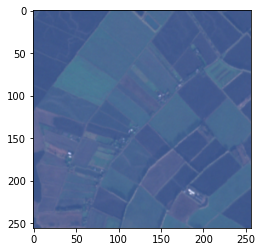

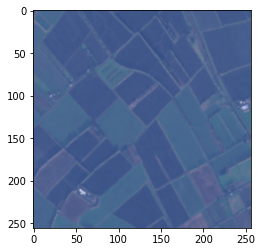

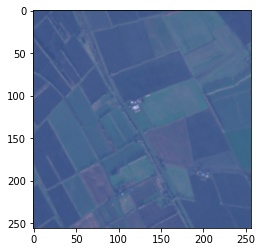

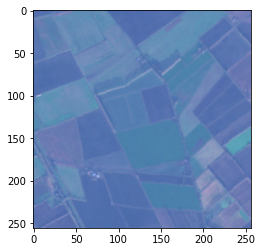

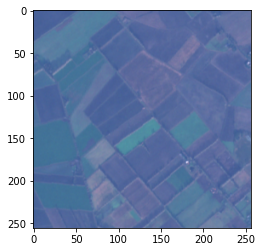

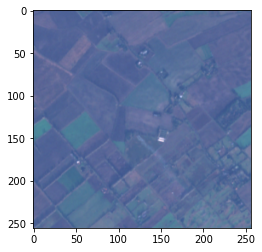

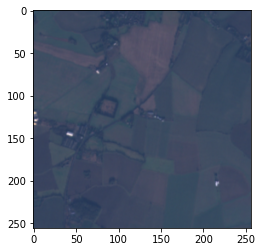

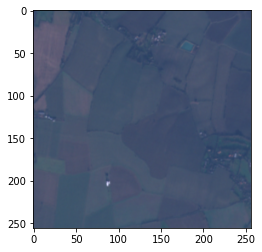

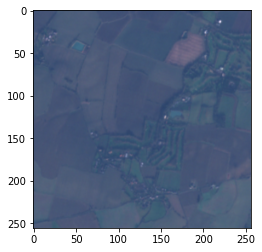

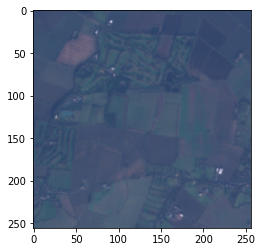

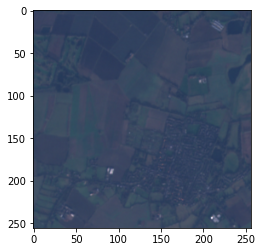

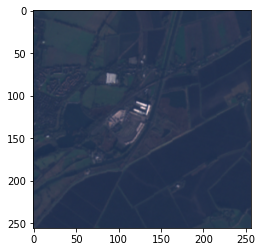

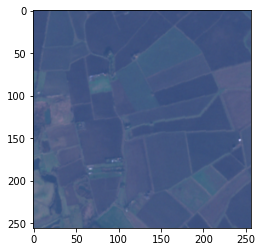

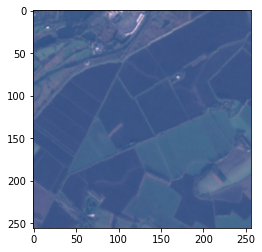

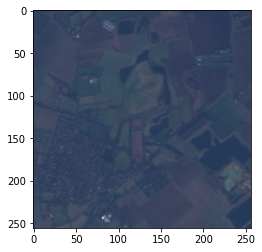

In [104]:
import matplotlib.image as mpimg

def process(data) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
   # <something gets done here>
    plt.figure()
    plt.imshow(data)

for x in patch_ids[45:60]:
    process(get_image(x))

(256, 256)


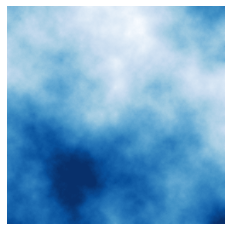

In [204]:
import numpy as np
import matplotlib.pyplot as plt

# The array must be square with edge length 2**n + 1
n = 8
N = 2**n + 1
# f scales the random numbers at each stage of the algorithm
f = 1.0

# Initialise the array with random numbers at its corners
arr = np.zeros((N, N))
arr[0::N-1,0::N-1] = np.random.uniform(-1, 1, (2,2))
side = N-1

nsquares = 1
while side > 1:
    sideo2 = side // 2

    # Diamond step
    for ix in range(nsquares):
        for iy in range(nsquares):
            x0, x1, y0, y1 = ix*side, (ix+1)*side, iy*side, (iy+1)*side
            xc, yc = x0 + sideo2, y0 + sideo2
            # Set this pixel to the mean of its "diamond" neighbours plus
            # a random offset.
            arr[yc,xc] = (arr[y0,x0] + arr[y0,x1] + arr[y1,x0] + arr[y1,x1])/4
            arr[yc,xc] += f * np.random.uniform(-1,1)

    # Square step: NB don't do this step until the pixels from the preceding
    # diamond step have been set.
    for iy in range(2*nsquares+1):
        yc = sideo2 * iy
        for ix in range(nsquares+1):
            xc = side * ix + sideo2 * (1 - iy % 2)
            if not (0 <= xc < N and 0 <= yc < N):
                continue
            tot, ntot = 0., 0
            # Set this pixel to the mean of its "square" neighbours plus
            # a random offset. At the edges, it has only three neighbours
            for (dx, dy) in ((-1,0), (1,0), (0,-1), (0,1)):
                xs, ys = xc + dx*sideo2, yc + dy*sideo2
                if not (0 <= xs < N and 0 <= ys < N):
                    continue
                else:
                    tot += arr[ys, xs]
                    ntot += 1
            arr[yc, xc] += tot / ntot + f * np.random.uniform(-1,1)
    side = sideo2
    nsquares *= 2
    f /= 2
arr = arr[1:,1:]

print(arr.shape)
for i in range(256):
    for j in range(256):
        
        if(arr[i][j]>0): arr[i][j]=0
        
plt.imshow(arr, cmap=plt.cm.Blues)
plt.axis('off')
plt.show()

In [168]:
arr

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [108]:
rgb  = get_image(patch_ids[154])
rgb.shape

(256, 256, 3)

NameError: name 'rbg' is not defined

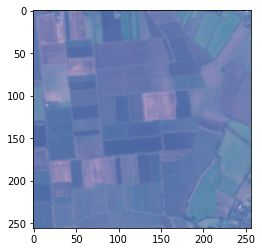

In [180]:
plt.figure()
plt.imshow(rgb)

In [77]:
rgb.paste(arr, (0,0), mask = img2)
  
# Displaying the image
img1.show()

AttributeError: 'numpy.ndarray' object has no attribute 'paste'

In [78]:
np.set_printoptions(threshold=np.inf)

In [181]:

from PIL import Image
  
# Opening the primary image (used in background)
img2 = Image.open('/home/surya/ecl/ecl codes/cdmask.png')
  
# Opening the secondary image (overlay image)
img1 = Image.open('/home/surya/ecl/ecl codes/sataimg.png')
  
# Pasting img2 image on top of img1 
# starting at coordinates (0, 0)
img1.paste(img2, (0,0), mask = img2)
  
# Displaying the image
img1.show()

In [202]:
mask = arr.copy()
sat = rgb.copy()

TypeError: 'numpy.bool_' object is not iterable

In [178]:
for i in range(256):
    for j in range(256):
        if(mask[i][j]!=0):
            sat[i][j][0]=mask[i][j]*100
            sat[i][j][1]=mask[i][j]*100
            sat[i][j][2]=mask[i][j]*100
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


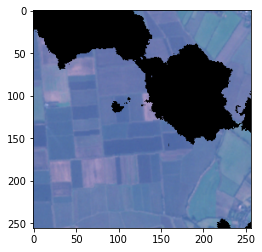

In [179]:
plt.figure()
plt.imshow(sat)

In [160]:
rgb

array([[[0.40090543, 0.48088531, 0.6861167 ],
        [0.40895372, 0.48641851, 0.68661972],
        [0.39939638, 0.47434608, 0.6971831 ],
        [0.40342052, 0.48289738, 0.69869215],
        [0.40593561, 0.49949698, 0.69064386],
        [0.40090543, 0.48541247, 0.68561368],
        [0.40241449, 0.48138833, 0.68661972],
        [0.42354125, 0.49597586, 0.69818913],
        [0.40442656, 0.48692153, 0.68460765],
        [0.38983903, 0.4778672 , 0.67555332],
        [0.44517103, 0.5       , 0.68863179],
        [0.47032193, 0.5055332 , 0.6971831 ],
        [0.47183099, 0.50804829, 0.71428571],
        [0.45975855, 0.50503018, 0.70674044],
        [0.42756539, 0.49698189, 0.69315895],
        [0.37173038, 0.49144869, 0.67756539],
        [0.36317907, 0.50100604, 0.67203219],
        [0.35764588, 0.49195171, 0.67002012],
        [0.34255533, 0.45975855, 0.65694165],
        [0.33651911, 0.44768612, 0.65643863],
        [0.32595573, 0.44818913, 0.65241449],
        [0.30231388, 0.43913481, 0